In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import PySimpleGUI as sg
import pyWinhook as pyHook
import pythoncom
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('keystroke.csv')

X = data.iloc[:, 3:]
y = data['subject']

# divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Create a Random Forest model
randomForestModel = RandomForestClassifier()

# Train the model
randomForestModel.fit(X_train, y_train)

# Evaluate the model on the test set
random_forest_accuracy = randomForestModel.score(X_test, y_test)
print('Test accuracy:', random_forest_accuracy)



Test accuracy: 0.9288334556126192


In [4]:
#accuracy of 0.74
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model
model = KNeighborsClassifier()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
knn_accuracy = model.score(X_test, y_test)
print('Test accuracy:', knn_accuracy)

Test accuracy: 0.7419907067742725


In [5]:
#accuracy of 0.72
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
model = LogisticRegression(max_iter=2000)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
logistic_regression_accuracy = model.score(X_test, y_test)
print('Test accuracy:', logistic_regression_accuracy)

Test accuracy: 0.7246270481780387


In [6]:
#accuracy of 0.72
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
decision_tree_accuracy = model.score(X_test, y_test)
print('Test accuracy:', decision_tree_accuracy)


Test accuracy: 0.7089752995842504


In [7]:
#accuracy of 0.79
from sklearn.svm import SVC

# Create an SVM model
model = SVC()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
svc_accuracy = model.score(X_test, y_test)
print('Test accuracy:', svc_accuracy)


Test accuracy: 0.7901687454145268


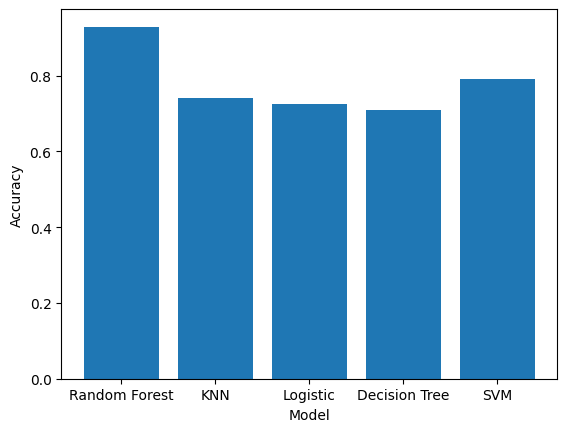

In [8]:
# Plot the accuracies
x = ['Random Forest', 'KNN', 'Logistic', 'Decision Tree', 'SVM']
y = [random_forest_accuracy, knn_accuracy, 
     logistic_regression_accuracy, decision_tree_accuracy, svc_accuracy]

plt.bar(x, y)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [9]:
class KeyLogger:
    def __init__(self):
        self.enterPressed = False
        self.eventList = []
        self.isCaps = False
        self.userName = getUserName()
        self.idOfWord = 1
        #self.message = ""

    def keyDownEvent(self, event):
        if event.KeyID == 20 and self.isCaps == False:
            self.isCaps = True
        elif event.KeyID == 20 and self.isCaps == True:
            self.isCaps = False     
        if event.KeyID>= 48 and event.KeyID<=57:
            event.Ascii = event.KeyID
        if self.isCaps == True and event.Ascii>=97 and event.Ascii<=122:
            event.Ascii = event.KeyID
        self.storeEvent("Down", event) 
        return True
    

    #Currently not used
    def mainLoop(self):
        while not self.enterPressed:
            pythoncom.PumpWaitingMessages()

            
    def keyUpEvent(self, event):
        if event.KeyID>= 48 and event.KeyID<=57:
            event.Ascii = event.KeyID
        if self.isCaps == True and event.Ascii>=97 and event.Ascii<=122:
            event.Ascii = event.KeyID
        print(chr(event.Ascii),end='')
        self.storeEvent("Up", event)
        return True


    def storeEvent(self, activity, event):
        keystrokeTime = int(event.Time)

        # Makes sure the enter key up and down have the same idOfWord
        if event.Ascii == 13 and activity == "Up":
            self.eventList.append ((self.userName, self.idOfWord - 1, event.Ascii, event.Key, activity, int(keystrokeTime)))
        else:
            self.eventList.append ((self.userName, self.idOfWord, event.Ascii, event.Key, activity, int(keystrokeTime)))

       
        
        
        # Chosen to use Escape key (ESC) due to input using a similar method
        # Enter Key - KeyCode: 13 Ascii: 13 ScanCode: 28 - ESC = 27 @ Ascii
        # Activity condition had to be added because the userRecordData function was being called twice because of the keyUpEvent and keyDownEvent
        # if event.Ascii == 13 and activity == "Down": 
        #     self.enterPressed = True
        #     print("Enter Pressed")
        #     userRecordData(self.eventList)

def userRecordData(eventList):
    
    
    
    # Delete the first element of the list because the first element is always a keyUpEvent for the Enter key
    if (eventList[0][3] == 'Return'):
        eventList.pop(0)  
    
    
    
    df = pd.DataFrame(eventList, columns = ['user', 'idOfWord', 'ascii', 'key', 'keyEvent', 'Time'])
    df = df[df.key != 'R']
    df2 = pd.DataFrame(columns=['subject','idOfWord','key','H','UD','DD'])
    print(df)
    for i in range(0, len(df), 2):
        finalData = {}

        finalData['subject'] = df.iloc[i].user
        finalData['key'] = df.iloc[i].key
        finalData['H'] = (int(df.iloc[i+1].Time) - int(df.iloc[i].Time))/1000
        finalData['idOfWord'] = df.iloc[i].idOfWord
        
        if(df.iloc[i].key != "Return"):
            finalData['UD'] = (int(df.iloc[i+2].Time) - int(df.iloc[i+1].Time))/1000
            finalData['DD'] = (int(df.iloc[i+2].Time) - int(df.iloc[i].Time))/1000
        
        df2 = pd.concat([df2, pd.DataFrame(finalData, index=[0])], ignore_index=True)

    df3 = pd.DataFrame(columns=['subject','H.period','DD.period.t','UD.period.t','H.t', 'DD.t.i', 'UD.t.i', 'H.i','DD.i.e','UD.i.e','H.e','DD.e.five', 'UD.e.five', 'H.five', 'DD.five.Shift.r', 'UD.five.Shift.r', 'H.Shift.r', 'DD.Shift.r.o', 'UD.Shift.r.o' , 'H.o', 'DD.o.a', 'UD.o.a', 'H.a', 'DD.a.n', 'UD.a.n', 'H.n', 'DD.n.l', 'UD.n.l', 'H.l', 'DD.l.Return', 'UD.l.Return', 'H.Return'])

    finalData = {}
    finalData['subject'] = df2.iloc[0].subject

    finalData['H.period'] = df2.iloc[0].H
    finalData['DD.period.t'] = df2.iloc[0].DD
    finalData['UD.period.t'] = df2.iloc[0].UD
    finalData['H.t'] = df2.iloc[1].H
    finalData['DD.t.i'] = df2.iloc[1].DD
    finalData['UD.t.i'] = df2.iloc[1].UD
    finalData['H.i'] = df2.iloc[2].H
    finalData['DD.i.e'] = df2.iloc[2].DD
    finalData['UD.i.e'] = df2.iloc[2].UD
    finalData['H.e'] = df2.iloc[3].H
    finalData['DD.e.five'] = df2.iloc[3].DD
    finalData['UD.e.five'] = df2.iloc[3].UD
    finalData['H.five'] = df2.iloc[4].H
    finalData['DD.five.Shift.r'] = df2.iloc[4].DD
    finalData['UD.five.Shift.r'] = df2.iloc[4].UD
    finalData['H.Shift.r'] = df2.iloc[5].H
    finalData['DD.Shift.r.o'] =    df2.iloc[5].DD
    finalData['UD.Shift.r.o'] = df2.iloc[5].UD
    finalData['H.o'] = df2.iloc[6].H
    finalData['DD.o.a'] = df2.iloc[6].DD
    finalData['UD.o.a'] = df2.iloc[6].UD
    finalData['H.a'] = df2.iloc[7].H
    finalData['DD.a.n'] = df2.iloc[7].DD
    finalData['UD.a.n'] = df2.iloc[7].UD
    finalData['H.n'] = df2.iloc[8].H
    finalData['DD.n.l'] = df2.iloc[8].DD
    finalData['UD.n.l'] =   df2.iloc[8].UD
    finalData['H.l'] = df2.iloc[9].H
    finalData['DD.l.Return'] = df2.iloc[9].DD
    finalData['UD.l.Return'] = df2.iloc[9].UD
    finalData['H.Return'] = df2.iloc[10].H
    df3 = pd.concat([df3, pd.DataFrame(finalData, index=[0])], ignore_index=True)

    prediction = randomForestModel.predict(df3.drop(['subject'], axis=1))
    print(prediction[0])
    print(df3['subject'].iloc[0])
    if prediction[0] == df3['subject'].iloc[0]:
        return True
    else:
        return False

#Not needed currently
def getKeyStroke():
    
    keyLogger = KeyLogger()
    hookManager = pyHook.HookManager()
    hookManager.KeyDown = keyLogger.keyDownEvent
    hookManager.KeyUp = keyLogger.keyUpEvent
    hookManager.HookKeyboard()

    keyLogger.mainLoop()
    # Unhooks the keyboard, no more data recorded, returns to menu
    hookManager.UnhookKeyboard()


def getUserName():
        userName = input("Enter your name: ")
        return userName

In [10]:
sg.theme('DarkAmber')   # Add a touch of color

keyLogger = KeyLogger()
hookManager = pyHook.HookManager()
hookManager.KeyDown = keyLogger.keyDownEvent
hookManager.KeyUp = keyLogger.keyUpEvent
hookManager.HookKeyboard()

# All the stuff inside your window.
layout = [  [sg.Text('Collecting KeyStroke Data for User: ' + keyLogger.userName)],
            [sg.Text('Enter password (.tie5Roanl)'), sg.InputText( key='Input1')],
            [sg.Button('Login'), sg.Button('Cancel')] ]

# Create the Window
window = sg.Window('Window Title', layout, finalize=True)

# Bind the Enter key to the input field -> Used to clear the input field when enter is pressed
# For this to work, when creating the window, finalize must be set to True
window['Input1'].bind('<Return>', '_Enter')

# Create the keylogger and hook it to the keyboard
# Event Loop to process "events" and get the "values" of the inputs
while True:
    event, values = window.read()
    if event == sg.WIN_CLOSED or event == 'Cancel': # if user closes window or clicks cancel
        break
    elif event == 'Input1' + '_Enter':
        window['Input1'].update('')
    elif event == 'Login': # This implementation prevents the same data from being recorded twice
        isAuthenticated = userRecordData(keyLogger.eventList)
        if(isAuthenticated):
            sg.popup('Welcome!')
        else:
            sg.popup('Invalid username or password.')
        break
    
    #keyLogger.mainLoop()
    pythoncom.PumpWaitingMessages() # This is needed for the keylogger to work, and works without the mainLoop function

    #print('You entered ', values[0])
    print(values)

# Unhooks the keyboard, no more data recorded, returns to menu
hookManager.UnhookKeyboard()
window.close()

.tie5 roanl{'Input1': '.tie5Roanl'}
     user  idOfWord  ascii         key keyEvent        Time
0   klara         1     46  Oem_Period     Down  1654558218
1   klara         1     46  Oem_Period       Up  1654558281
2   klara         1    116           T     Down  1654558437
3   klara         1    116           T       Up  1654558546
4   klara         1    105           I     Down  1654558578
5   klara         1    105           I       Up  1654558656
6   klara         1    101           E     Down  1654558718
7   klara         1    101           E       Up  1654558828
8   klara         1     53           5     Down  1654558984
9   klara         1     53           5       Up  1654559078
10  klara         1      0      Lshift     Down  1654559203
12  klara         1      0      Lshift       Up  1654559406
14  klara         1    111           O     Down  1654559546
15  klara         1    111           O       Up  1654559656
16  klara         1     97           A     Down  1654559734
17  

In [11]:
#accuracy of 0.72
# from sklearn.linear_model import LogisticRegression

# # Create a Logistic Regression model
# model = LogisticRegression(max_iter=2000)

# # Train the model
# model.fit(X_train, y_train)

# # Evaluate the model on the test set
# accuracy = model.score(X_test, y_test)
# print('Test accuracy:', accuracy)


In [12]:
#accuracy of 0.84
# from sklearn.preprocessing import StandardScaler

# # Scale the input features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create a Logistic Regression model and train it on the scaled data
# model = LogisticRegression(solver='sag', max_iter=5000)
# model.fit(X_train_scaled, y_train)

# # Evaluate the model on the scaled test set
# accuracy = model.score(X_test_scaled, y_test)
# print('Test accuracy:', accuracy)


In [13]:
#accuracy of 0.72
# from sklearn.tree import DecisionTreeClassifier

# # Create a Decision Tree model
# model = DecisionTreeClassifier()

# # Train the model
# model.fit(X_train, y_train)

# # Evaluate the model on the test set
# accuracy = model.score(X_test, y_test)
# print('Test accuracy:', accuracy)


In [14]:
#accuracy of 0.79
# from sklearn.svm import SVC

# # Create an SVM model
# model = SVC()

# # Train the model
# model.fit(X_train, y_train)

# # Evaluate the model on the test set
# accuracy = model.score(X_test, y_test)
# print('Test accuracy:', accuracy)


In [15]:
#accuracy of 0.74
# from sklearn.neighbors import KNeighborsClassifier

# # Create a KNN model
# model = KNeighborsClassifier()

# # Train the model
# model.fit(X_train, y_train)

# # Evaluate the model on the test set
# accuracy = model.score(X_test, y_test)
# print('Test accuracy:', accuracy)